In [1]:
import os
import json
import shutil
import pandas as pd
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/PoseDetection/'

In [4]:
source_folder = '/content/drive/My Drive/PoseDetection/cleaned_frames'
destination_folder = '/content/data/'

# Copy the entire contents of the source folder to the destination folder
shutil.copytree(source_folder, destination_folder)

'/content/data/'

In [5]:
train_data = pd.read_csv(os.path.join(path, 'annotations.csv'))

In [6]:
display(train_data)

,image_path,exercise,keypoints,movement,correctness
0,cleaned_frames\train\push up\-3pjDfx73Aw_frame...,pushup,"{""nose"": [0.7804315686225891, 0.62957674264907...",other,False
1,cleaned_frames\train\push up\-3pjDfx73Aw_frame...,pushup,"{""nose"": [0.7804315686225891, 0.62957674264907...",other,False
2,cleaned_frames\train\push up\-3pjDfx73Aw_frame...,pushup,"{""nose"": [0.7804315686225891, 0.62957674264907...",other,False
3,cleaned_frames\train\push up\-3pjDfx73Aw_frame...,pushup,"{""nose"": [0.7838078737258911, 0.79867374897003...",flexion,True
4,cleaned_frames\train\push up\-3pjDfx73Aw_frame...,pushup,"{""nose"": [0.7780419588088989, 0.64591157436370...",other,False
...,...,...,...,...,...
14242,cleaned_frames\train\deadlifting\_VfIXeIsDgs_f...,deadlift,"{""nose"": [0.3229900300502777, 0.35340684652328...",flexion,True
14243,cleaned_frames\train\deadlifting\_VfIXeIsDgs_f...,deadlift,"{""nose"": [0.3036998510360718, 0.43158715963363...",flexion,True
14244,cleaned_frames\train\deadlifting\_VfIXeIsDgs_f...,deadlift,"{""nose"": [0.4848771393299103, 0.23012197017669...",extension,True
14245,cleaned_frames\train\deadlifting\_XvgoY7cupA_f...,deadlift,"{""nose"": [0.19773268699645996, 0.4894666373729...",flexion,True


In [7]:
display(train_data.shape)

(14247, 5)

In [8]:
test_data = pd.read_csv(os.path.join(path, 'annotations_val.csv'))

In [9]:
display(test_data)

,image_path,exercise,keypoints,movement,correctness
0,cleaned_frames\val\push up\AFF5uioXScE_frame_0...,pushup,"{""nose"": [0.3410030007362366, 0.75547808408737...",extension,True
1,cleaned_frames\val\push up\AFF5uioXScE_frame_0...,pushup,"{""nose"": [0.3410030007362366, 0.75547808408737...",extension,True
2,cleaned_frames\val\push up\AFF5uioXScE_frame_0...,pushup,"{""nose"": [0.3079437017440796, 0.76787388324737...",extension,True
3,cleaned_frames\val\push up\AFF5uioXScE_frame_0...,pushup,"{""nose"": [0.3108583688735962, 0.76549476385116...",extension,True
4,cleaned_frames\val\push up\AFF5uioXScE_frame_0...,pushup,"{""nose"": [0.30108994245529175, 0.7984157204627...",flexion,True
...,...,...,...,...,...
657,cleaned_frames\val\deadlifting\FgWbtbaDr_M_fra...,deadlift,"{""nose"": [0.4749700725078583, 0.11717641353607...",extension,True
658,cleaned_frames\val\deadlifting\fijFfqFVuqY_fra...,deadlift,"{""nose"": [0.8271400332450867, 0.36212331056594...",flexion,True
659,cleaned_frames\val\deadlifting\fijFfqFVuqY_fra...,deadlift,"{""nose"": [0.8638302087783813, 0.35206997394561...",flexion,True
660,cleaned_frames\val\deadlifting\fijFfqFVuqY_fra...,deadlift,"{""nose"": [0.8474545478820801, 0.34521526098251...",flexion,True


In [10]:
display(test_data.shape)

(662, 5)

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms

In [40]:
class PoseDataset(Dataset):
    def __init__(self, images_folder, df, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing image information like key points, labels, etc.
            images_folder (str): Folder path to extract images from.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.df = df

        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.images_folder, self.df.iloc[idx]['image_path'])
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        correct = self.df.iloc[idx]['correctness']
        correct = torch.tensor(correct, dtype=torch.long)

        return image, correct

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [14]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels, keypoints(1D array), movement and correctness
train_data['keypoints'] = train_data['keypoints'].apply(lambda x: [val for sublist in json.loads(x).values() for val in sublist])

train_data['image_path'] = train_data['image_path'].apply(lambda path: path.replace("\\", "/"))
train_data['image_path'] = train_data['image_path'].apply(lambda path: "/".join(path.split("/")[1:]))

train_data['exercise'] = label_encoder.fit_transform(train_data['exercise'])
exercise_classes = label_encoder.classes_

train_data['movement'] = label_encoder.fit_transform(train_data['movement'])
movement_classes = label_encoder.classes_

train_data['correctness'] = train_data['correctness'].map({False: 0, True: 1})
train_data['correctness'] = train_data['correctness'].astype(bool)

display(exercise_classes)
display(movement_classes)
display(train_data)

array(['deadlift', 'pushup', 'squat'], dtype=object)

array(['extension', 'flexion', 'other'], dtype=object)

,image_path,exercise,keypoints,movement,correctness
0,train/push up/-3pjDfx73Aw_frame_0001.png,1,"[0.7804315686225891, 0.6295767426490784, -0.22...",2,False
1,train/push up/-3pjDfx73Aw_frame_0002.png,1,"[0.7804315686225891, 0.6295767426490784, -0.22...",2,False
2,train/push up/-3pjDfx73Aw_frame_0003.png,1,"[0.7804315686225891, 0.6295767426490784, -0.22...",2,False
3,train/push up/-3pjDfx73Aw_frame_0004.png,1,"[0.7838078737258911, 0.7986737489700317, -0.11...",1,True
4,train/push up/-3pjDfx73Aw_frame_0005.png,1,"[0.7780419588088989, 0.6459115743637085, -0.24...",2,False
...,...,...,...,...,...
14242,train/deadlifting/_VfIXeIsDgs_frame_0006.png,0,"[0.3229900300502777, 0.3534068465232849, -0.17...",1,True
14243,train/deadlifting/_VfIXeIsDgs_frame_0007.png,0,"[0.3036998510360718, 0.4315871596336365, -0.05...",1,True
14244,train/deadlifting/_VfIXeIsDgs_frame_0008.png,0,"[0.4848771393299103, 0.23012197017669678, -0.1...",0,True
14245,train/deadlifting/_XvgoY7cupA_frame_0007.png,0,"[0.19773268699645996, 0.4894666373729706, -0.0...",1,True


In [15]:
# Fit and transform the labels, movement and correctness
test_data['keypoints'] = test_data['keypoints'].apply(lambda x: [val for sublist in json.loads(x).values() for val in sublist])

test_data['image_path'] = test_data['image_path'].apply(lambda path: path.replace("\\", "/"))
test_data['image_path'] = test_data['image_path'].apply(lambda path: "/".join(path.split("/")[1:]))

test_data['exercise'] = label_encoder.fit_transform(test_data['exercise'])
exercise_classes = label_encoder.classes_

test_data['movement'] = label_encoder.fit_transform(test_data['movement'])
movement_classes = label_encoder.classes_

test_data['correctness'] = test_data['correctness'].map({False: 0, True: 1})
test_data['correctness'] = test_data['correctness'].astype(bool)

display(exercise_classes)
display(movement_classes)
display(test_data)

array(['deadlift', 'pushup', 'squat'], dtype=object)

array(['extension', 'flexion', 'other'], dtype=object)

,image_path,exercise,keypoints,movement,correctness
0,val/push up/AFF5uioXScE_frame_0001.png,1,"[0.3410030007362366, 0.7554780840873718, 0.013...",0,True
1,val/push up/AFF5uioXScE_frame_0002.png,1,"[0.3410030007362366, 0.7554780840873718, 0.013...",0,True
2,val/push up/AFF5uioXScE_frame_0003.png,1,"[0.3079437017440796, 0.7678738832473755, 0.061...",0,True
3,val/push up/AFF5uioXScE_frame_0004.png,1,"[0.3108583688735962, 0.7654947638511658, 0.104...",0,True
4,val/push up/AFF5uioXScE_frame_0005.png,1,"[0.30108994245529175, 0.7984157204627991, 0.06...",1,True
...,...,...,...,...,...
657,val/deadlifting/FgWbtbaDr_M_frame_0009.png,0,"[0.4749700725078583, 0.11717641353607178, -0.5...",0,True
658,val/deadlifting/fijFfqFVuqY_frame_0007.png,0,"[0.8271400332450867, 0.3621233105659485, -0.12...",1,True
659,val/deadlifting/fijFfqFVuqY_frame_0008.png,0,"[0.8638302087783813, 0.3520699739456177, -0.18...",1,True
660,val/deadlifting/fijFfqFVuqY_frame_0009.png,0,"[0.8474545478820801, 0.3452152609825134, -0.23...",1,True


In [16]:
# Making sure that all the images have a uniform struction.
# Reduced the size of the image for faster processing of the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),                  # Resizes the image to 64 * 64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalizes the data
])

### Creating training and testing datasets

In [17]:
src_path = '/content/data'

In [41]:
train_dataset = PoseDataset(src_path, train_data, transform=transform)

In [42]:
test_dataset = PoseDataset(src_path, test_data, transform=transform)

### Create data loaders

In [43]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [44]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [45]:
display(len(train_loader))

3562

In [46]:
display(len(test_loader))

166

### Creating the CNN model

In [24]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
class PoseCNN(nn.Module):
  def __init__(self):
    super(PoseCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # Added padding
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Added padding
    self.fc1 = nn.Linear(64 * 16 * 16, 128)                   # Adjusted input size
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))  # Output: 32x32x32
    x = self.pool(F.relu(self.conv2(x)))  # Output: 64x16x16
    x = torch.flatten(x, 1)               # Flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    x = self.sigmoid(x)
    return x

In [26]:
sum(p.numel() for p in PoseCNN().parameters() if p.requires_grad)

2126465

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Training the model

In [51]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # for images, keypoints, angles, labels, correct in train_loader:

    for images, corrects in train_loader:
      images, labels = images.to(device), corrects.to(device).float()

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs.squeeze(), labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

In [48]:
num_epochs = 25

In [52]:
model = PoseCNN().to(device)

criterion = nn.BCELoss()                                    
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train_model(model, train_loader, criterion, optimizer, num_epochs)

<ipython-input-40-f6849b661fbb>:28: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  correct = torch.tensor(correct, dtype=torch.long)


Epoch [1/25], Loss: 0.5625
Epoch [2/25], Loss: 0.4620
Epoch [3/25], Loss: 0.3391
Epoch [4/25], Loss: 0.2520
Epoch [5/25], Loss: 0.1922
Epoch [6/25], Loss: 0.1509
Epoch [7/25], Loss: 0.1267
Epoch [8/25], Loss: 0.1013
Epoch [9/25], Loss: 0.0801
Epoch [10/25], Loss: 0.0741
Epoch [11/25], Loss: 0.0651
Epoch [12/25], Loss: 0.0602
Epoch [13/25], Loss: 0.0570
Epoch [14/25], Loss: 0.0540
Epoch [15/25], Loss: 0.0465
Epoch [16/25], Loss: 0.0451
Epoch [17/25], Loss: 0.0410
Epoch [18/25], Loss: 0.0380
Epoch [19/25], Loss: 0.0351
Epoch [20/25], Loss: 0.0462
Epoch [21/25], Loss: 0.0350
Epoch [22/25], Loss: 0.0336
Epoch [23/25], Loss: 0.0373
Epoch [24/25], Loss: 0.0313
Epoch [25/25], Loss: 0.0388


In [53]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0

        for images, correct in test_loader:
            images, labels = images.to(device), correct.to(device).float()
            outputs = model(images)
            predicted = (outputs.squeeze() > 0.5).float()
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        accuracy = 100 * correct_predictions / total_predictions
        print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

In [54]:
test_model(model, test_loader)

<ipython-input-40-f6849b661fbb>:28: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  correct = torch.tensor(correct, dtype=torch.long)


Accuracy of the network on the test images: 64.35%


In [55]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Printing the classification report for precision

In [56]:
def print_classification_report(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, correct in dataloader:
            # Move images and labels to the device
            images, correct = images.to(device), correct.to(device).float()

            # Forward pass
            outputs = model(images)

            # Convert outputs to binary predictions
            predicted = (outputs.squeeze() > 0.5).float()

            # Store labels and predictions
            all_labels.extend(correct.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    print(classification_report(all_labels, all_predictions))

In [57]:
print_classification_report(model, test_loader, device)

<ipython-input-40-f6849b661fbb>:28: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  correct = torch.tensor(correct, dtype=torch.long)


              precision    recall  f1-score   support

         0.0       0.26      0.28      0.27       156
         1.0       0.77      0.75      0.76       506

    accuracy                           0.64       662
   macro avg       0.52      0.52      0.52       662
weighted avg       0.65      0.64      0.65       662



In [58]:
import matplotlib.pyplot as plt

In [59]:
def plot_confusion_matrix(model, dataloader, device, dataset_type='train'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, correct in dataloader:
            images, labels = images.to(device), correct.to(device).float()
            outputs = model(images)
            preds = (outputs.squeeze() > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.title(f'{dataset_type.capitalize()} Confusion Matrix')
    plt.show()

## Confusion Matrix Plots

<ipython-input-40-f6849b661fbb>:28: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  correct = torch.tensor(correct, dtype=torch.long)


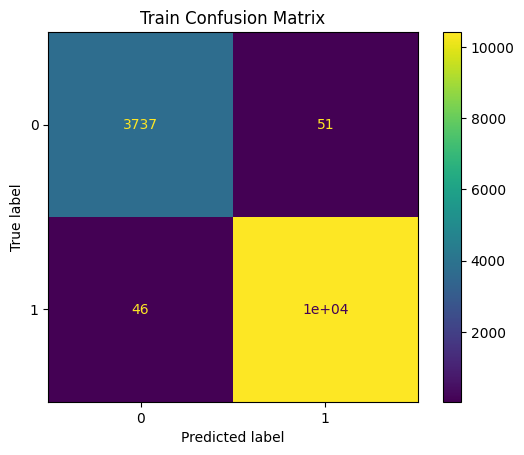

In [60]:
# Plot confusion matrix for training set
plot_confusion_matrix(model, train_loader, device, dataset_type='train')

<ipython-input-40-f6849b661fbb>:28: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  correct = torch.tensor(correct, dtype=torch.long)


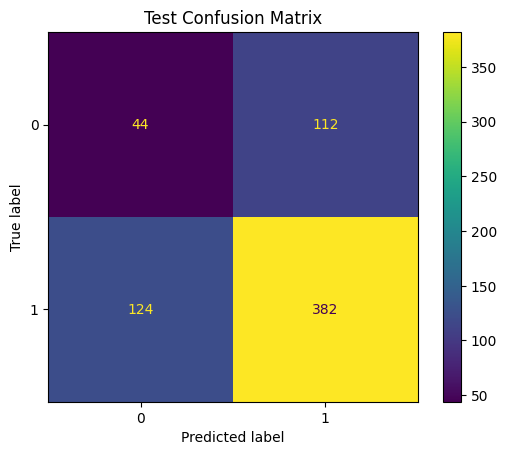

In [61]:
# Plot confusion matrix for test set
plot_confusion_matrix(model, test_loader, device, dataset_type='test')